# Autralia Fertility Data - Pre-processing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

df = pd.read_csv("Australiafertility.csv")

ages = df["age"].to_numpy()
year_cols = [c for c in df.columns if c != "age"]
years = np.array([int(c) for c in year_cols])

# matrix: rows = ages, cols = years 
rates = df[year_cols].to_numpy()
smoothed = np.zeros_like(rates)

df.head(5)

,age,1921,1922,1923,1924,1925,1926,1927,1928,1929,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,15,1.749997,1.589998,1.589998,1.709998,2.099998,2.399997,2.300000,2.399998,2.499998,...,2.633619,3.342309,3.405054,3.666621,3.111861,2.857143,2.931257,2.701424,2.384142,2.148757
1,16,6.843768,6.595236,6.854068,7.474161,8.094822,8.693913,8.319840,8.995146,9.295174,...,6.684994,6.972223,7.953156,7.593783,7.028858,6.635372,6.614941,5.783921,4.903513,4.476864
2,17,18.277846,18.981300,19.651100,21.684603,22.278423,22.481338,24.406602,24.574205,25.071629,...,14.128215,13.685640,15.431949,14.626299,13.905542,13.642071,13.522309,11.571730,9.572760,8.903475
3,18,39.182681,39.482735,41.025837,42.774534,44.559839,44.210914,47.252429,47.512808,46.592520,...,23.545704,23.803101,25.659265,24.390591,23.404054,22.650467,22.716018,20.233057,17.416039,16.142488
4,19,67.528095,65.188310,66.777261,65.687389,70.048438,69.859469,70.473679,71.963729,68.011228,...,32.718113,35.600269,36.637912,35.039902,33.652595,31.672058,32.219773,30.342590,27.525540,25.523773


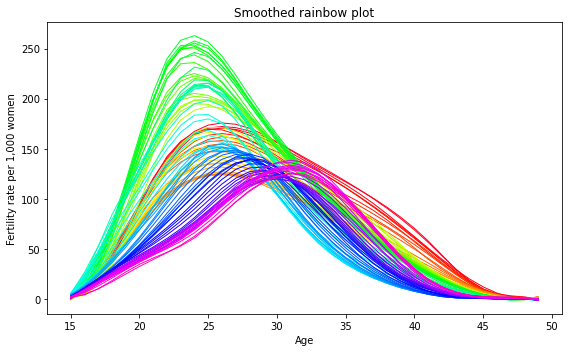

In [2]:
# Smooth each year curve as a function of age
for i in range(rates.shape[1]): # Loop over each year
    # Build the spline f_i(x) that minimizes reconstruction error + smoothing penalty (Second derivative):
    spl = UnivariateSpline(ages, rates[:, i], s=50.0)  
    smoothed[:, i] = spl(ages) # Evaluate that function at all ages (y = f_i(x_j)) and store the smooth curve

# plot
cmap = plt.colormaps["gist_rainbow"]
colors = cmap(np.linspace(0, 1, len(years)))

plt.figure(figsize=(8, 5))
for i, year in enumerate(years):
    plt.plot(ages, smoothed[:, i], color=colors[i], lw=1)

plt.xlabel("Age")
plt.ylabel("Fertility rate per 1,000 women")
plt.title("Smoothed rainbow plot")
plt.tight_layout()
plt.show()

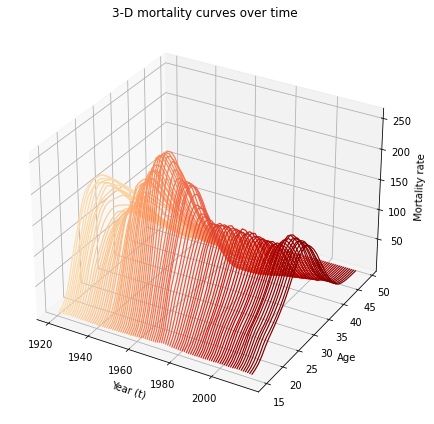

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3d projection

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.colormaps["OrRd"] # gradient colors
colors = cmap(np.linspace(0.2, 1, len(years)))

for i, year in enumerate(years):
    ax.plot(
        np.full_like(ages, year),   # time (t) axis
        ages,                       # age axis
        rates[:, i],                # mortality values
        color=colors[i],
        linewidth=1.2
    )

ax.set_xlabel("Year (t)")
ax.set_ylabel("Age")
ax.set_zlabel("Mortality rate")
ax.set_title("3-D mortality curves over time")

plt.tight_layout()
plt.show()

## FAE Model

In [7]:
# ============================================================
# Functional Autoencoder (FAE) for Australia Fertility Data
# ============================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

# Reproducibility
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# -------------------------
# 1) Load & preprocess Australia fertility data
# -------------------------
df = pd.read_csv("Australiafertility.csv")

# Age grid and year labels
ages = df["age"].to_numpy()          # shape [n_age]
year_cols = [c for c in df.columns if c != "age"]
years = np.array([int(c) for c in year_cols])

# matrix: rows = ages, cols = years 
rates = df[year_cols].to_numpy()     # shape [n_age, n_year]

# For FAE, we want: rows = samples, cols = time points.
# Use smoothed data as the curves
x_raw = smoothed.T.astype(float)      # [n_year, n_age]

# Centralizing the data 
x = torch.tensor(x_raw, dtype=torch.float32)
x_mean = torch.mean(x, dim=0)         # [n_age], mean over years
x_centered = x - x_mean               # this goes into the FAE

# Time grid: rescale ages to [0,1]
tpts_np = ages.astype(float)
tpts_rescale = (tpts_np - tpts_np.min()) / (tpts_np.max() - tpts_np.min())
tpts = torch.tensor(tpts_rescale, dtype=torch.float32)
n_tpts = len(tpts)


# -------------------------
# 2) Basis construction (Fourier + Bspline)
# -------------------------
class BasisFCBuilder:
    """
    Build basis matrix evaluated on tpts.

    Usage:
        builder = BasisFCBuilder(n_basis=20, basis_type="Fourier")
        B = builder.build(tpts)  # or builder(tpts)

    Output shape: [n_time, n_basis]
    """
    def __init__(self, n_basis=20, basis_type="Fourier", custom_basis_fn=None,
                 bspline_degree=3):
        self.n_basis = n_basis
        self.basis_type = basis_type  # keep original string for error msgs
        self.basis_type_l = basis_type.lower()
        self.custom_basis_fn = custom_basis_fn
        self.bspline_degree = bspline_degree  # e.g. 3 for cubic B-spline

    def __call__(self, tpts):
        return self.build(tpts)

    def build(self, tpts: torch.Tensor):
        """
        tpts: 1D tensor of time/age points, shape [n_time].
        Returns: basis matrix B, shape [n_time, n_basis].
        """
        # Custom basis overrides everything
        if self.custom_basis_fn is not None:
            B = self.custom_basis_fn(tpts)
            if not torch.is_tensor(B):
                B = torch.tensor(B, dtype=torch.float32)
            return B.float()

        if self.basis_type_l == "fourier":
            return self._build_fourier(tpts)
        elif self.basis_type_l in ("bspline", "b-spline", "b_spline"):
            return self._build_bspline(tpts, degree=self.bspline_degree)
        else:
            raise ValueError("basis_type must be 'Fourier' or 'Bspline'.")

    # ---------- Fourier basis ----------
    def _build_fourier(self, tpts: torch.Tensor):
        """
        Simple Fourier basis on [min(t), max(t)].

        B[:,0] = 1
        B[:,1], B[:,2] = sin(2π t_norm), cos(2π t_norm)
        B[:,3], B[:,4] = sin(4π t_norm), cos(4π t_norm)
        ...
        """
        t = tpts.flatten()
        t_min = t.min()
        t_max = t.max()
        denom = (t_max - t_min).clamp_min(1e-8)
        tau = (t - t_min) / denom  # normalized to [0,1]

        n_time = tpts.shape[0]
        n_basis = self.n_basis
        device = t.device

        B = torch.zeros(n_time, n_basis, dtype=torch.float32, device=device)

        # constant term
        if n_basis > 0:
            B[:, 0] = 1.0

        # sin/cos pairs
        k = 1
        idx = 1
        while idx < n_basis:
            B[:, idx] = torch.sin(2.0 * math.pi * k * tau)
            idx += 1
            if idx < n_basis:
                B[:, idx] = torch.cos(2.0 * math.pi * k * tau)
                idx += 1
            k += 1

        return B

    # ---------- B-spline basis ----------
    def _build_bspline(self, tpts: torch.Tensor, degree: int = 3):
        """
        Build a B-spline basis of given degree over [min(t), max(t)],
        using an open uniform knot vector.

        Returns B with shape [n_time, n_basis].
        """
        t = tpts.flatten()
        t_min = t.min()
        t_max = t.max()
        denom = (t_max - t_min).clamp_min(1e-8)
        tau = (t - t_min) / denom  # normalize to [0,1]
        tau_np = tau.detach().cpu().numpy()  # [n_time]

        n_time = tau_np.shape[0]
        n_basis = self.n_basis
        p = degree

        if n_basis < p + 1:
            raise ValueError(
                f"Bspline: n_basis={n_basis} must be at least degree+1={p+1}."
            )

        # Open uniform knot vector on [0,1]
        # len(knots) = n_basis + p + 1
        # number of interior knots = n_basis - p - 1 (may be 0)
        n_int = max(n_basis - p - 1, 0)
        if n_int > 0:
            interior = np.linspace(0.0, 1.0, n_int + 2)[1:-1]  # drop endpoints
            knots = np.concatenate((
                np.zeros(p + 1),
                interior,
                np.ones(p + 1),
            ))
        else:
            # just endpoints repeated
            knots = np.concatenate((
                np.zeros(p + 1),
                np.ones(p + 1),
            ))

        # Cox–de Boor recursion
        # N has shape [n_basis, n_time]
        N = np.zeros((n_basis, n_time), dtype=np.float64)

        # degree 0
        for i in range(n_basis):
            left = knots[i]
            right = knots[i + 1]
            # standard definition: [left, right)
            N[i, :] = np.where(
                (tau_np >= left) & (tau_np < right),
                1.0,
                0.0
            )
        # special case: at tau == 1, put all mass on the last basis
        N[-1, tau_np == 1.0] = 1.0

        # build up to degree p
        for k in range(1, p + 1):
            N_next = np.zeros_like(N)
            for i in range(n_basis):
                # left term
                denom_left = knots[i + k] - knots[i]
                if denom_left > 0:
                    coeff_left = (tau_np - knots[i]) / denom_left
                    N_left = coeff_left * N[i, :]
                else:
                    N_left = 0.0

                # right term
                denom_right = knots[i + k + 1] - knots[i + 1] if (i + 1) < n_basis else 0.0
                if denom_right > 0 and (i + 1) < n_basis:
                    coeff_right = (knots[i + k + 1] - tau_np) / denom_right
                    N_right = coeff_right * N[i + 1, :]
                else:
                    N_right = 0.0

                N_next[i, :] = N_left + N_right

            N = N_next

        # N: [n_basis, n_time] -> B: [n_time, n_basis]
        B_np = N.T
        B = torch.tensor(B_np, dtype=torch.float32, device=tpts.device)
        return B


# -------------------------
# 3) FAE model (linear)
# -------------------------
class FAEVanilla(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, init_weight_sd=None):
        super().__init__()
        self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()  # linear FAE

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    def project(self, x, tpts, basis_fc):
        """
        x: [batch, n_time]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time]
        returns: [batch, n_basis]

        Uses trapezoidal rule weights from time grid.
        """
        t = tpts.flatten()
        dt = t[1:] - t[:-1]

        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # [n_time]

        n_time = x.shape[1]
        if basis_fc.shape[0] == n_time:
            B = basis_fc
        elif basis_fc.shape[1] == n_time:
            B = basis_fc.T
        else:
            raise RuntimeError(
                f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_time={n_time}"
            )

        return (x * W) @ B

    def revert(self, coef, basis_fc):
        """
        coef: [batch, n_basis]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time]
        returns: [batch, n_time]
        """
        n_basis = coef.shape[1]
        if basis_fc.shape[1] == n_basis:
            return coef @ basis_fc.T   # basis_fc: [n_time, n_basis]
        elif basis_fc.shape[0] == n_basis:
            return coef @ basis_fc     # basis_fc: [n_basis, n_time]
        else:
            raise RuntimeError(
                f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_basis={n_basis}"
            )

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)
        rep = self.activation(self.encoder(feature))
        coef = self.decoder(rep)
        x_hat = self.revert(coef, basis_fc_revert)
        return x_hat, rep, feature, coef


# -------------------------
# 4) Penalty (smoothness)
# -------------------------
def diff_penalty(coef):
    """
    Smoothness penalty on decoded coeffs (second finite difference).
    coef: [batch, n_basis]
    """
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))


# -------------------------
# 5) Train / evaluate
# -------------------------
def train_one_epoch(model, loader, optimizer, loss_fn, device,
                    tpts, basis_fc_project, basis_fc_revert,
                    pen=None, lamb=0.0):

    model.train()
    total_loss = 0.0
    total_score_loss = 0.0
    n_batches = 0

    for x_batch in loader:
        x_batch = x_batch.to(device).float()
        optimizer.zero_grad()

        x_hat, rep, feature, coef = model(x_batch, tpts, basis_fc_project, basis_fc_revert)

        loss = loss_fn(x_hat, x_batch)

        # optional score loss if feature and coef are same shape
        score_loss = 0.0
        if feature.shape == coef.shape:
            score_loss = loss_fn(feature, coef)
            total_score_loss += float(score_loss.detach().cpu())

        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
        n_batches += 1

    return total_loss / max(n_batches, 1), total_score_loss / max(n_batches, 1)


@torch.no_grad()
def evaluate(model, x_data, loss_fn, device, tpts, basis_fc_project, basis_fc_revert):
    """
    Returns:
        x_hat, rep, loss, coef
    """
    model.eval()
    x_data = x_data.to(device).float()
    x_hat, rep, feature, coef = model(x_data, tpts, basis_fc_project, basis_fc_revert)
    loss = loss_fn(x_hat, x_data)
    return x_hat, rep, float(loss.detach().cpu()), coef


# -------------------------
# 6) Main experiment (unsupervised)
# -------------------------
def run_fae_experiment(
    x,
    tpts,
    n_iter=1,
    split_rate=0.8,
    epochs=2000,
    batch_size=16,
    n_rep=5,                   # latent dimension
    n_basis_project=20,
    n_basis_revert=20,
    basis_type_project="Fourier",
    basis_type_revert="Fourier",
    custom_basis_project_fn=None,
    custom_basis_revert_fn=None,
    pen="diff",
    lamb=0.001,
    lr=1e-3,
    weight_decay=1e-6,
    init_weight_sd=0.5,
    log_every=100,
    device="cpu",
    seed=743,
    save_extras=True
):
    """
    Unsupervised FAE training.

    Returns history dict with:
      - train/test final recon loss per replicate
      - per-epoch (every log_every) train/test recon loss (lists across replicates)
      - optional extras from last replicate (model, data, etc.)
    """
    set_seed(seed)
    device = torch.device(device)

    # basis builders
    basis_project_builder = BasisFCBuilder(
        n_basis=n_basis_project,
        basis_type=basis_type_project,
        custom_basis_fn=custom_basis_project_fn
    )
    basis_revert_builder = BasisFCBuilder(
        n_basis=n_basis_revert,
        basis_type=basis_type_revert,
        custom_basis_fn=custom_basis_revert_fn
    )

    # basis matrices
    basis_fc_project = basis_project_builder.build(tpts.to(device)).to(device)
    basis_fc_revert = basis_revert_builder.build(tpts.to(device)).to(device)

    tpts = tpts.to(device).float()
    loss_fn = nn.MSELoss()

    n_log_points = epochs // log_every

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "per_epoch_train_recon_loss": [[] for _ in range(n_log_points)],
        "per_epoch_test_recon_loss": [[] for _ in range(n_log_points)],
    }

    # ensure x is tensor (n_samples, n_time)
    if not torch.is_tensor(x):
        x_tensor = torch.tensor(x, dtype=torch.float32)
    else:
        x_tensor = x.float()

    idx_all = np.arange(x_tensor.shape[0])

    for r in range(n_iter):
        idx_train, idx_test = train_test_split(
            idx_all,
            train_size=split_rate,
            random_state=seed + r,
            shuffle=True
        )

        TrainData = x_tensor[idx_train]
        TestData = x_tensor[idx_test]

        train_loader = DataLoader(TrainData, batch_size=batch_size, shuffle=True)

        model = FAEVanilla(
            n_basis_project, n_rep, n_basis_revert, init_weight_sd=init_weight_sd
        ).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(1, epochs + 1):
            train_loss, score_loss = train_one_epoch(
                model, train_loader, optimizer, loss_fn, device,
                tpts, basis_fc_project, basis_fc_revert,
                pen=pen, lamb=lamb
            )

            if epoch % log_every == 0:
                _, _, train_loss_eval, _ = evaluate(
                    model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
                )
                _, _, test_loss, _ = evaluate(
                    model, TestData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
                )

                k = (epoch // log_every) - 1
                history["per_epoch_train_recon_loss"][k].append(train_loss_eval)
                history["per_epoch_test_recon_loss"][k].append(test_loss)

                print(
                    f"[rep {r+1}/{n_iter}] epoch {epoch:4d} | "
                    f"train_loss={train_loss_eval:.6f} | test_loss={test_loss:.6f}"
                )

        # final eval
        _, _, train_loss, _ = evaluate(
            model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
        )
        _, _, test_loss, _ = evaluate(
            model, TestData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert
        )

        history["train_recon_loss"].append(train_loss)
        history["test_recon_loss"].append(test_loss)

        print(f"Replicate {r+1} complete.\n")

        if save_extras and (r == n_iter - 1):
            history["extras"] = {
                "model": model,
                "TrainData": TrainData,
                "TestData": TestData,
                "tpts": tpts,
                "basis_fc_project": basis_fc_project,
                "basis_fc_revert": basis_fc_revert,
                "device": device,
                "loss_fn": loss_fn,
                "years": years,
                "ages": ages,
            }

    return history


# -------------------------
# 7) Plotting helper
# -------------------------
def plot_history(history, log_every=100):
    train_mse_mean = [np.mean(v) for v in history["per_epoch_train_recon_loss"]]
    train_mse_sd   = [np.std(v)  for v in history["per_epoch_train_recon_loss"]]

    test_mse_mean  = [np.mean(v) for v in history["per_epoch_test_recon_loss"]]
    test_mse_sd    = [np.std(v)  for v in history["per_epoch_test_recon_loss"]]

    epochs_grid = np.arange(log_every, len(train_mse_mean) * log_every + 1, log_every)

    plt.figure()
    plt.plot(epochs_grid, train_mse_mean, '-o', label='Train MSE')
    plt.fill_between(
        epochs_grid,
        np.array(train_mse_mean) - np.array(train_mse_sd),
        np.array(train_mse_mean) + np.array(train_mse_sd),
        alpha=0.2
    )
    plt.plot(epochs_grid, test_mse_mean, '-o', label='Test MSE')
    plt.fill_between(
        epochs_grid,
        np.array(test_mse_mean) - np.array(test_mse_sd),
        np.array(test_mse_mean) + np.array(test_mse_sd),
        alpha=0.2
    )
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('FAE Reconstruction Error over Training')
    plt.legend()
    plt.tight_layout()
    plt.show()

[rep 1/1] epoch  100 | train_loss=180.479736 | test_loss=141.612503
[rep 1/1] epoch  200 | train_loss=31.996012 | test_loss=27.586449
[rep 1/1] epoch  300 | train_loss=21.184084 | test_loss=19.763779
[rep 1/1] epoch  400 | train_loss=15.928661 | test_loss=15.545333
[rep 1/1] epoch  500 | train_loss=12.297909 | test_loss=12.294218
[rep 1/1] epoch  600 | train_loss=10.505471 | test_loss=10.684622
[rep 1/1] epoch  700 | train_loss=9.844866 | test_loss=10.106894
[rep 1/1] epoch  800 | train_loss=9.476808 | test_loss=9.778259
[rep 1/1] epoch  900 | train_loss=9.171625 | test_loss=9.481322
[rep 1/1] epoch 1000 | train_loss=8.877478 | test_loss=9.203747
[rep 1/1] epoch 1100 | train_loss=8.551195 | test_loss=8.871531
[rep 1/1] epoch 1200 | train_loss=8.112000 | test_loss=8.408555
[rep 1/1] epoch 1300 | train_loss=7.431209 | test_loss=7.713402
[rep 1/1] epoch 1400 | train_loss=6.426061 | test_loss=6.642788
[rep 1/1] epoch 1500 | train_loss=5.301911 | test_loss=5.436591
[rep 1/1] epoch 1600 | tr

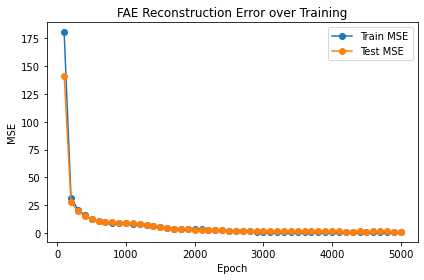

In [8]:
# -------------------------
# 8) Run the experiment
# -------------------------
if __name__ == "__main__":
    history = run_fae_experiment(
        x=x_centered,              # centered fertility curves, shape [n_year, n_age]
        tpts=tpts,        # rescaled ages in [0,1]
        n_iter=1,
        epochs=5000,
        log_every=100,
        basis_type_project="Bspline",
        basis_type_revert="Bspline",
        n_rep=5,              # latent dimension
        n_basis_project=20,
        n_basis_revert=20,
        device="cpu",
    )
    
# MSE train and test plot
plot_history(history, log_every=100)

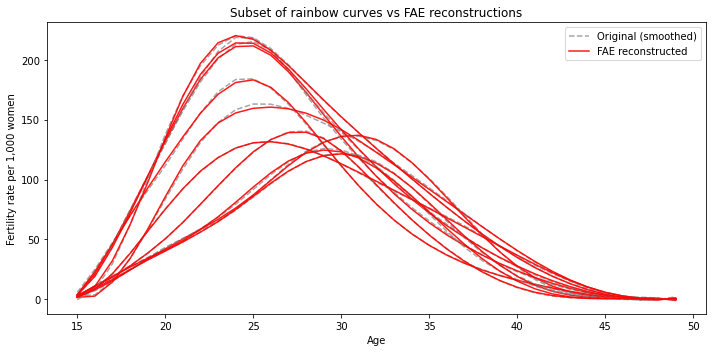

In [10]:
# Original vs reconstructed on the fertility scale
extras = history["extras"]
model = extras["model"]
TrainData = extras["TrainData"]   # centered smoothed curves
TestData = extras["TestData"]
tpts = extras["tpts"]
basis_fc_project = extras["basis_fc_project"]
basis_fc_revert = extras["basis_fc_revert"]
device = extras["device"]

model.eval()
with torch.no_grad():
    x_hat_centered, reps, _, _ = model(
        TestData.to(device),
        tpts,
        basis_fc_project,
        basis_fc_revert
    )

# Move to CPU
x_hat_centered = x_hat_centered.cpu()
Test_centered = TestData.cpu()

# Add the mean curve back: now in fertility scale (smoothed)
x_mean_cpu = x_mean.cpu()
orig_rates = Test_centered + x_mean_cpu        # [n_test, n_age]
recon_rates = x_hat_centered + x_mean_cpu      # [n_test, n_age]

# Pick a few years to show
import random
idxs = random.sample(range(orig_rates.shape[0]), 10)

plt.figure(figsize=(10, 5))
for k, i in enumerate(idxs):
    plt.plot(
        ages,
        orig_rates[i].numpy(),
        '--',
        color='gray',
        alpha=0.7,
        label='Original (smoothed)' if k == 0 else ''
    )
    plt.plot(
        ages,
        recon_rates[i].numpy(),
        color='red',
        alpha=0.9,
        label='FAE reconstructed' if k == 0 else ''
    )

plt.xlabel("Age")
plt.ylabel("Fertility rate per 1,000 women")
plt.title("Subset of rainbow curves vs FAE reconstructions")
plt.legend()
plt.tight_layout()
plt.show()
